In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import subprocess as sp
import itertools as it

In [2]:
serial_dir = "../Serial/data.csv"
parallel_seq_dir = "../ParallelSeq/data.csv"
parallel_grid_dir = "../ParallelGrid/data.csv"

In [3]:
serial_data = pd.read_csv(serial_dir, sep=", ", engine="python")
parallel_seq_data = pd.read_csv(parallel_seq_dir, sep=", ", engine="python")
parallel_grid_data = pd.read_csv(parallel_grid_dir, sep=", ", engine="python")

In [4]:
num_iters = max(serial_data["iterations"])
print(num_iters)

serial_data = serial_data[serial_data["iterations"] == num_iters]
serial_data["threads"] = 1
serial_data["size"] = serial_data["size_x"] * serial_data["size_y"]

parallel_seq_data = parallel_seq_data[parallel_seq_data["iterations"] == num_iters]
parallel_seq_data["size"] = parallel_seq_data["size_x"] * parallel_seq_data["size_y"]

parallel_grid_data = parallel_grid_data[parallel_grid_data["iterations"] == num_iters]
parallel_grid_data["size"] = parallel_grid_data["size_x"] * parallel_grid_data["size_y"]

10000


In [5]:
def plotCellsRuntime(dataFrame: pd.DataFrame, ax: plt.Axes, label: str):
    threads = dataFrame["threads"].unique()
    
    for t in threads:
        # Plot the data
        data = dataFrame[dataFrame["threads"] == t]
        sizes = data["size"].unique()
        times = np.array([
            data[data["size"] == s]["total_runtime"].mean()
            for s in sizes
        ])
        # Fit a linear model to the log-log data
        x = np.log10(sizes).reshape(-1, 1)
        y = np.log10(times).reshape(-1, 1)
        model = LinearRegression()
        model.fit(x, y)
        
        # Annotate the plot with the slope
        ax.scatter(sizes, times, marker="x")
        ax.plot(sizes, times, label="{} - {} threads | slope: {:.4f}".format(label, t, model.coef_[0][0]))

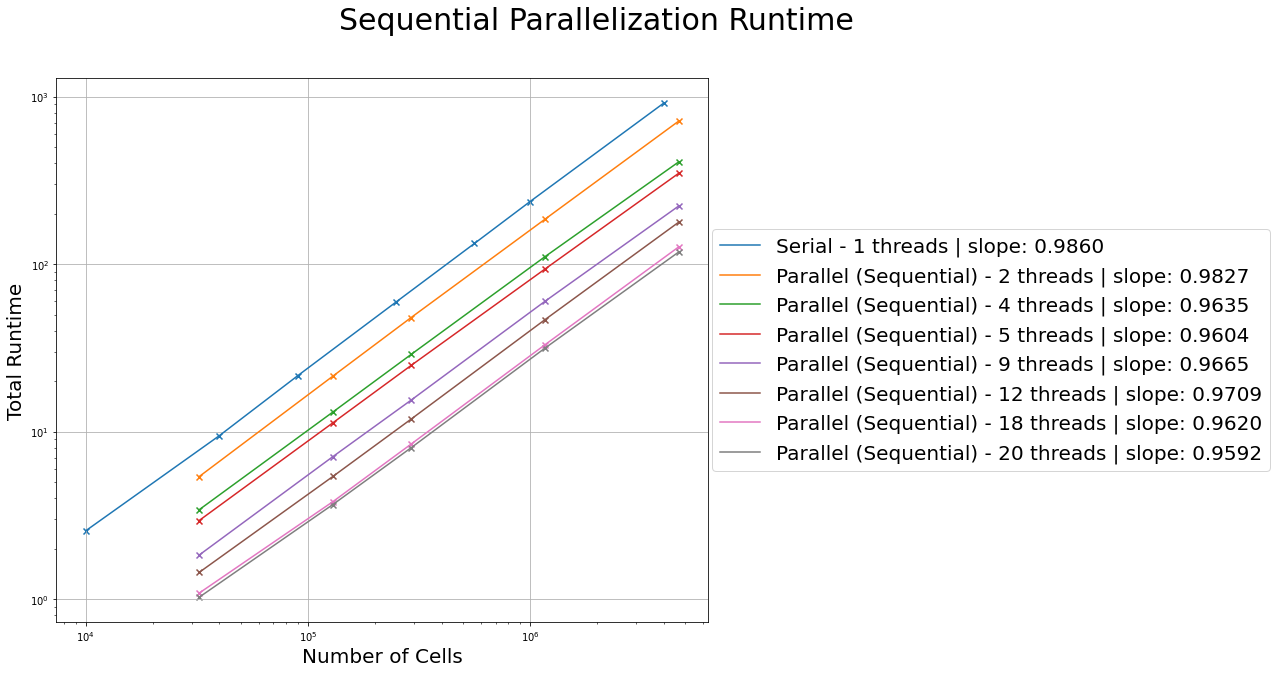

In [6]:
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 10),
    gridspec_kw={"width_ratios": [1.8, 1]}
)
fig.suptitle("Sequential Parallelization Runtime", size=30)

# Plot runtime vs. number of cells
plotCellsRuntime(serial_data, ax[0], "Serial")
plotCellsRuntime(parallel_seq_data, ax[0], "Parallel (Sequential)")

# Get the legend handles and labels
h, l = ax[0].get_legend_handles_labels()

# Set labels
ax[0].grid()
ax[0].set_xlabel("Number of Cells", size=20)
ax[0].set_xscale("log")
ax[0].set_ylabel("Total Runtime", size=20)
ax[0].set_yscale("log")

# Add the legend
ax[1].legend(h, l, fontsize=20, loc="center")
ax[1].axis("off")

# Show the plot
plt.show()

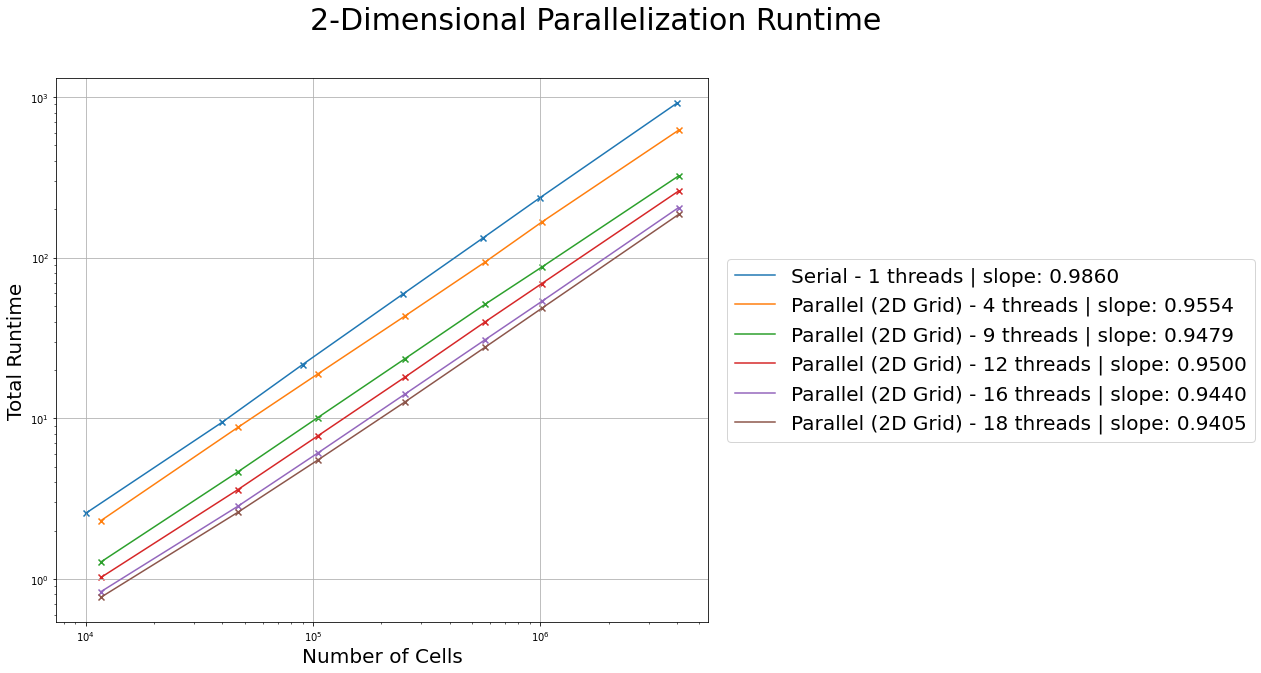

In [7]:
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 10),
    gridspec_kw={"width_ratios": [1.8, 1]}
)
fig.suptitle("2-Dimensional Parallelization Runtime", size=30)

# Plot runtime vs. number of cells
plotCellsRuntime(serial_data, ax[0], "Serial")
plotCellsRuntime(parallel_grid_data, ax[0], "Parallel (2D Grid)")

# Get the legend handles and labels
h, l = ax[0].get_legend_handles_labels()

# Set labels
ax[0].grid()
ax[0].set_xlabel("Number of Cells", size=20)
ax[0].set_xscale("log")
ax[0].set_ylabel("Total Runtime", size=20)
ax[0].set_yscale("log")

# Add the legend
ax[1].legend(h, l, fontsize=20, loc="center")
ax[1].axis("off")

# Show the plot
plt.show()

In [8]:
def plotSpeedupEfficiency(serialDataFrame: pd.DataFrame, dataFrame: pd.DataFrame, ax_s: plt.Axes, ax_e:plt.Axes, label: str):
    threads = dataFrame["threads"].unique()
    serial_sizes = serialDataFrame["size"].unique()
    serial_times = np.array([
            serialDataFrame[serialDataFrame["size"] == s]["total_runtime"].mean()
            for s in serial_sizes
        ])
        
    for t in threads:
        # Get the parallel data
        data = dataFrame[dataFrame["threads"] == t]
        sizes = data["size"].unique()
        times = np.array([
            data[data["size"] == s]["total_runtime"].mean()
            for s in sizes
        ])
        # Fit a linear model to the log-log data
        x = np.log10(sizes).reshape(-1, 1)
        y = np.log10(times).reshape(-1, 1)
        model = LinearRegression()
        model.fit(x, y)
        
        # Predict parallel times for serial sizes
        serial_x = np.log10(serial_sizes).reshape(-1, 1)
        prediction = np.array([
            10**val[0] for val in
            model.predict(serial_x)
        ])
        
        # Calculate speedup
        speedup = serial_times / prediction
        
        # Plot the speedup
        ax_s.scatter(serial_sizes, speedup, marker="x")
        ax_s.plot(serial_sizes, speedup, label="{} - {} threads".format(label, t))
        
        # Plot the effieciency
        ax_e.scatter(serial_sizes, speedup / t, marker="x")
        ax_e.plot(serial_sizes, speedup / t, label="{} - {} threads".format(label, t))

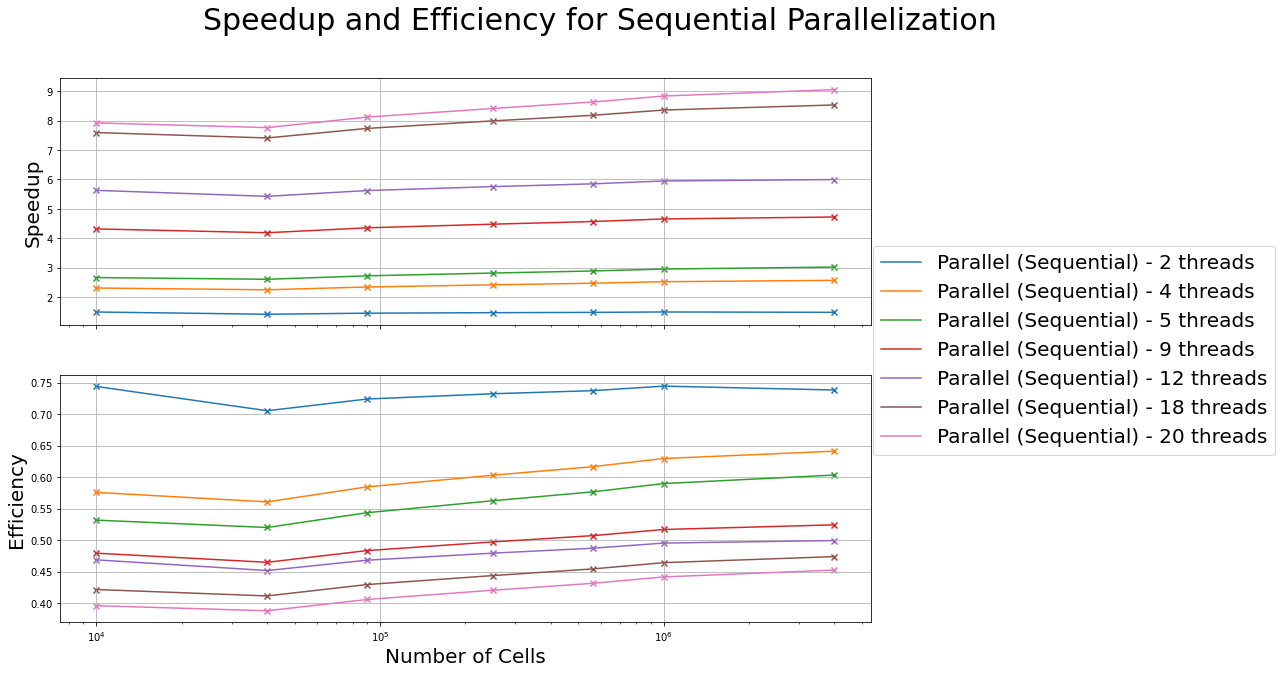

In [9]:
fig, ax = plt.subplots(
    nrows=2, ncols=2,
    figsize=(20, 10),
    sharex=True,
    gridspec_kw={"width_ratios": [4, 1]}
)
fig.suptitle("Speedup and Efficiency for Sequential Parallelization", size=30)

# Create grid spec for the legend
gs = ax[0, 1].get_gridspec()
for a in ax[0:, -1]:
    a.remove()
legend_ax = fig.add_subplot(gs[0:, -1])

# Plot the speedup and efficiency
plotSpeedupEfficiency(serial_data, parallel_seq_data, ax[0, 0], ax[1,0], "Parallel (Sequential)")

# Get the legend handles and labels
h, l = ax[0, 0].get_legend_handles_labels()

# Set labels
ax[0, 0].grid()
ax[1, 0].grid()
ax[0, 0].set_xscale("log")
ax[0, 0].set_ylabel("Speedup", size=20)
ax[1, 0].set_xscale("log")
ax[1, 0].set_xlabel("Number of Cells", size=20)
ax[1, 0].set_ylabel("Efficiency", size=20)

# Add the legend
legend_ax.legend(h, l, fontsize=20, loc="center")
legend_ax.axis("off")

# Show the plot
plt.show()

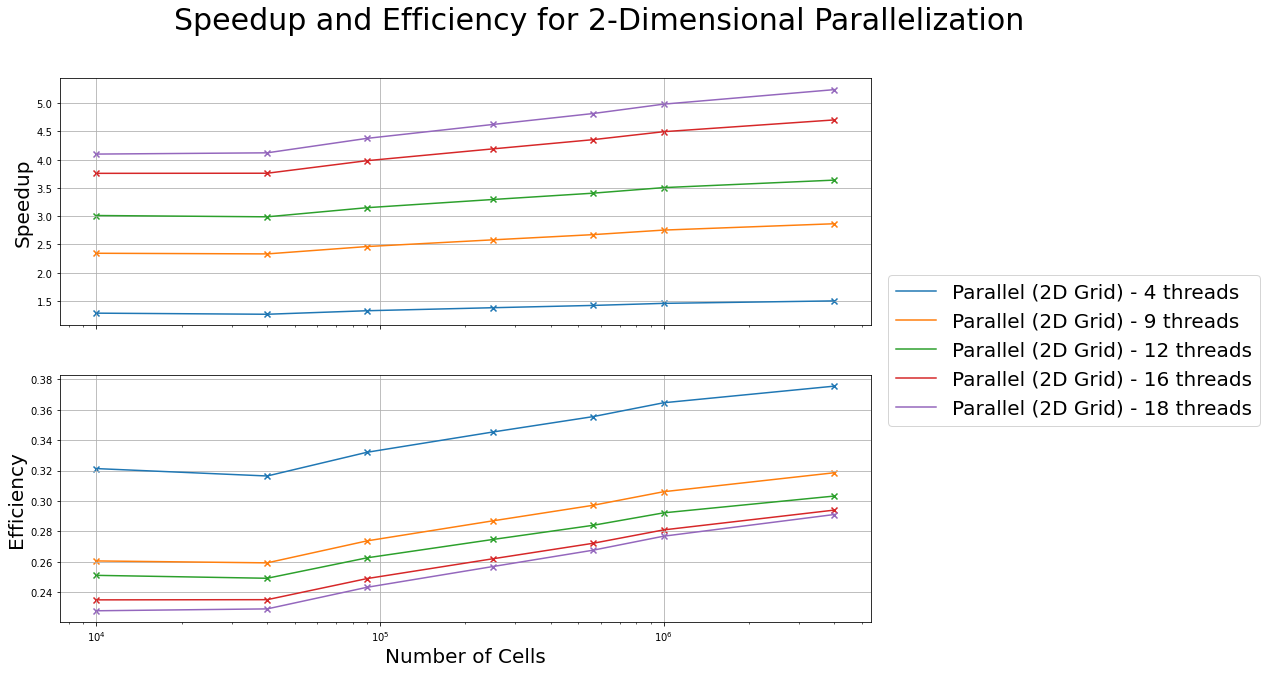

In [10]:
fig, ax = plt.subplots(
    nrows=2, ncols=2,
    figsize=(20, 10),
    sharex=True,
    gridspec_kw={"width_ratios": [4, 1]}
)
fig.suptitle("Speedup and Efficiency for 2-Dimensional Parallelization", size=30)

# Create grid spec for the legend
ax[0, 0].grid()
ax[1, 0].grid()
gs = ax[0, 1].get_gridspec()
for a in ax[0:, -1]:
    a.remove()
legend_ax = fig.add_subplot(gs[0:, -1])

# Plot the speedup and efficiency
plotSpeedupEfficiency(serial_data, parallel_grid_data, ax[0, 0], ax[1,0], "Parallel (2D Grid)")

# Get the legend handles and labels
h, l = ax[0, 0].get_legend_handles_labels()

# Set labels
ax[0, 0].set_xscale("log")
ax[0, 0].set_ylabel("Speedup", size=20)
ax[1, 0].set_xscale("log")
ax[1, 0].set_xlabel("Number of Cells", size=20)
ax[1, 0].set_ylabel("Efficiency", size=20)

# Add the legend
legend_ax.legend(h, l, fontsize=20, loc="center")
legend_ax.axis("off")

# Show the plot
plt.show()

In [11]:
def plotCommTime(dataFrame: pd.DataFrame, ax: plt.Axes, label: str):
    threads = dataFrame["threads"].unique()
        
    for t in threads:
        # Get the parallel data
        data = dataFrame[dataFrame["threads"] == t]
        sizes = data["size"].unique()
        run_times = np.array([
            data[data["size"] == s]["total_runtime"].mean()
            for s in sizes
        ])
        comm_times = np.array([
            data[data["size"] == s]["comm_time"].mean()
            for s in sizes
        ])
        
        # Calculate ratio of run_time to comm_time
        ratio = run_times / comm_times
        
        # Plot the ratio
        ax.scatter(sizes, ratio, marker="x")
        ax.plot(sizes, ratio, label="{} - {} threads".format(label, t))

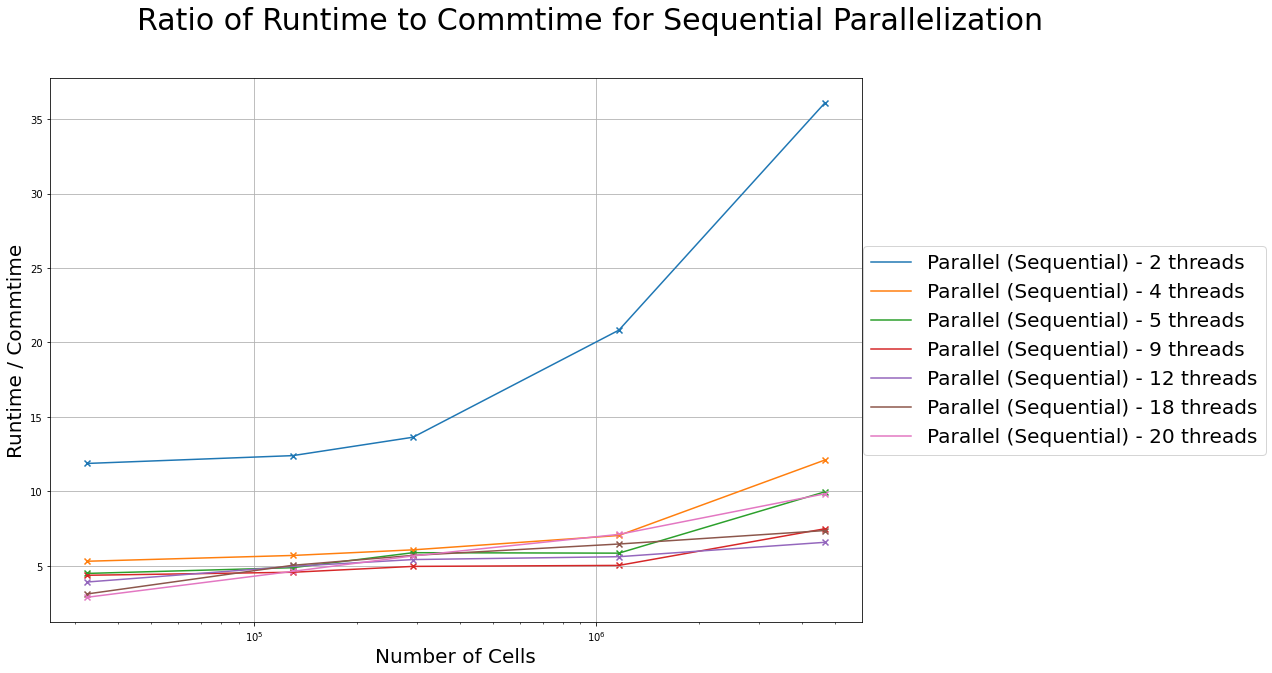

In [12]:
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 10),
    gridspec_kw={"width_ratios": [4, 1]}
)
fig.suptitle("Ratio of Runtime to Commtime for Sequential Parallelization", size=30)

# Plot ratio of run_time to comm_time
plotCommTime(parallel_seq_data, ax[0], "Parallel (Sequential)")

# Get the legend handles and labels
h, l = ax[0].get_legend_handles_labels()

# Set labels
ax[0].grid()
ax[0].set_xlabel("Number of Cells", size=20)
ax[0].set_xscale("log")
ax[0].set_ylabel("Runtime / Commtime", size=20)

# Add the legend
ax[1].legend(h, l, fontsize=20, loc="center")
ax[1].axis("off")

# Show the plot
plt.show()

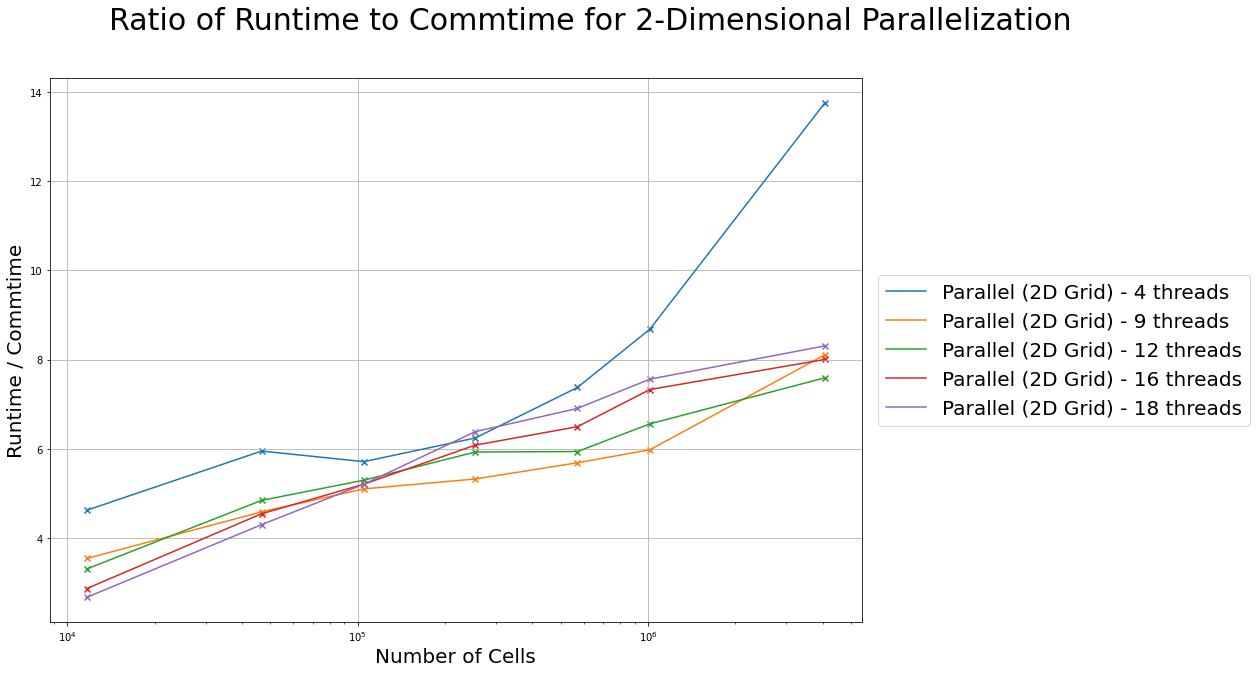

In [13]:
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 10),
    gridspec_kw={"width_ratios": [4, 1]}
)
fig.suptitle("Ratio of Runtime to Commtime for 2-Dimensional Parallelization", size=30)

# Plot ratio of run_time to comm_time
plotCommTime(parallel_grid_data, ax[0], "Parallel (2D Grid)")

# Get the legend handles and labels
h, l = ax[0].get_legend_handles_labels()

# Set labels
ax[0].grid()
ax[0].set_xlabel("Number of Cells", size=20)
ax[0].set_xscale("log")
ax[0].set_ylabel("Runtime / Commtime", size=20)

# Add the legend
ax[1].legend(h, l, fontsize=20, loc="center")
ax[1].axis("off")

# Show the plot
plt.show()